In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_path = "datasets/readings.xlsx"

In [3]:
df = pd.read_excel(data_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7409 entries, 0 to 7408
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Num                   7409 non-null   int64  
 1   Timestamp             7409 non-null   object 
 2   Current_J0            7363 non-null   float64
 3   Temperature_T0        7355 non-null   float64
 4   Current_J1            7355 non-null   float64
 5   Temperature_J1        7355 non-null   float64
 6   Current_J2            7355 non-null   float64
 7   Temperature_J2        7355 non-null   float64
 8   Current_J3            7355 non-null   float64
 9   Temperature_J3        7355 non-null   float64
 10  Current_J4            7355 non-null   float64
 11  Temperature_J4        7355 non-null   float64
 12  Current_J5            7355 non-null   float64
 13  Temperature_J5        7355 non-null   float64
 14  Speed_J0              7355 non-null   float64
 15  Speed_J1             

In [7]:
df["Robot_ProtectiveStop"] = df["Robot_ProtectiveStop"].astype(bool)
df["Robot_ProtectiveStop"]

0       False
1       False
2       False
3       False
4       False
        ...  
7404    False
7405    False
7406    False
7407    False
7408    False
Name: Robot_ProtectiveStop, Length: 7409, dtype: bool

In [9]:
df['Timestamp']

0       2022-10-26T08:17:21.847Z
1       2022-10-26T08:17:22.852Z
2       2022-10-26T08:17:23.857Z
3       2022-10-26T08:17:24.863Z
4       2022-10-26T08:17:25.877Z
                  ...           
7404    2022-10-26T15:36:02.555Z
7405    2022-10-26T15:36:03.562Z
7406    2022-10-26T15:36:04.571Z
7407    2022-10-26T15:36:05.572Z
7408    2022-10-26T15:36:06.580Z
Name: Timestamp, Length: 7409, dtype: object

In [7]:
df['Timestamp'] = df['Timestamp'].apply(lambda x: x[11:-5])
df['Timestamp']

0       08:17:21
1       08:17:22
2       08:17:23
3       08:17:24
4       08:17:25
          ...   
7404    15:36:02
7405    15:36:03
7406    15:36:04
7407    15:36:05
7408    15:36:06
Name: Timestamp, Length: 7409, dtype: object

## To do:
- Check different locations where grip_lost and Robot_ProtectiveStop change from False to True
- Identify if the cycle is correlated to this issue
- Check the current and speed of the joints before each failure for a specific window
- If faults are more likely to happen if there are nan values

## Exploratory Data Analysis

In [15]:
print(df['grip_lost'].value_counts())
print(df['Robot_ProtectiveStop'].value_counts())

grip_lost
False    7166
True      243
Name: count, dtype: int64
Robot_ProtectiveStop
False    7077
True      332
Name: count, dtype: int64


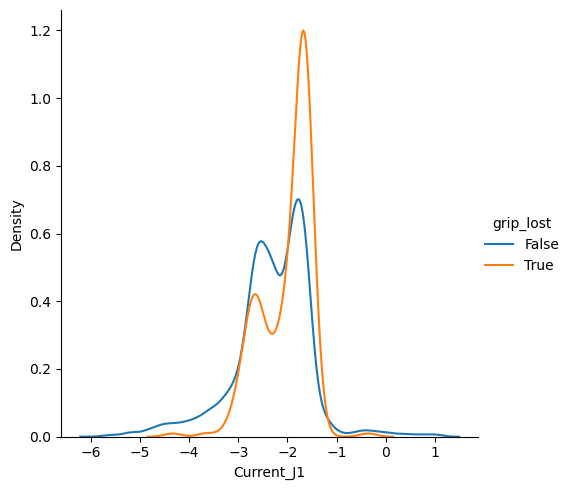

In [364]:
joint = 'Current_J1'
sns.FacetGrid(df, height=5, hue="grip_lost").map(sns.kdeplot, f"{joint}").add_legend()

Most failures happen when Joint J1, J2, and J3 are supplied with negative current

In [19]:
stop_faults = df[df['Robot_ProtectiveStop'] == 1]
grip_faults = df[df['grip_lost'] == 1]
print("Protective Stop - Mean Temp T0:", stop_faults['Temperature_T0'].mean())
print("Grip Lost - Mean Temp J0:", grip_faults['Temperature_T0'].mean())

Protective Stop - Mean Temp T0: 35.725044964028775
Grip Lost - Mean Temp J0: 33.60390946502058


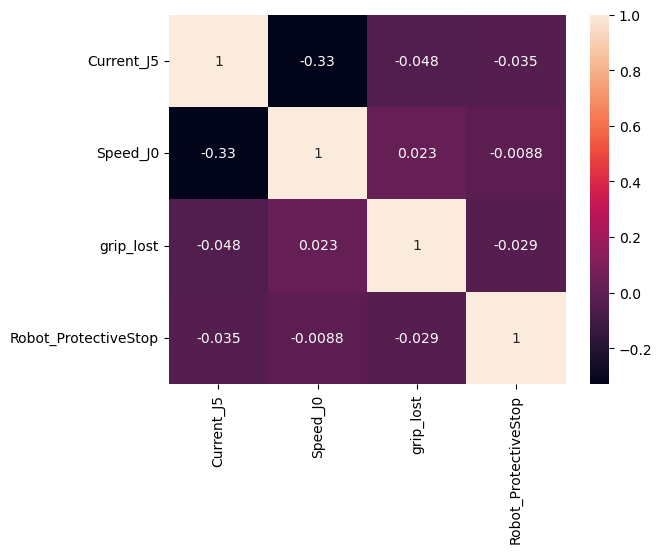

In [22]:
sns.heatmap(df[['Current_J5', 'Speed_J0', 'grip_lost', 'Robot_ProtectiveStop']].corr(), annot=True)
plt.show()

High corr with current_j5 and speed_j4. Mid corr with current_j1 and speed_j0. Mid corr with current_j2 and speed_j2. Mid corr with current_j2 and speed_j5. Mid corr with current_j3 and speed_j3. Low corr with 'Current_J3', 'Speed_J0'. Low corr with 'Current_J4', 'Speed_J1'. Low corr with 'Current_J5', 'Speed_J5'

In [25]:
df['Fault'] = df['Robot_ProtectiveStop'] | df['grip_lost']
# df[(df.Robot_ProtectiveStop == True) and (df.grip_lost == True)]

In [27]:
fault_df = df[df['Fault'] == 1]
neg_current_faults = fault_df[(fault_df['Current_J1'] < 0) | 
                              (fault_df['Current_J2'] < 0) | 
                              (fault_df['Current_J3'] < 0)]
print(f"Percentage of faults with negative currents: {len(neg_current_faults) / len(fault_df) * 100:.2f}%")

Percentage of faults with negative currents: 89.69%


Nearly all faults happen during the phase where **negative current** is supplied to joints **J1, J2, and J3**. This means that the error happens when:
- The joints are slowing down (approaching the place where the part will be placed)
- The joints are moving in the opposite direction (negative current signifies torque in the other direction)
- Certain configurations result in failure from the (defined by the cycle class)

In [30]:
grip_lost = df[df['grip_lost'] == 1]
protective_stop = df[df['Robot_ProtectiveStop'] == 1]
print("Grip Lost with negative currents:", 
      len(grip_lost[(grip_lost['Current_J1'] < 0) | 
                    (grip_lost['Current_J2'] < 0) | 
                    (grip_lost['Current_J3'] < 0)]) / len(grip_lost) * 100)
print("Protective Stop with negative currents:", 
      len(protective_stop[(protective_stop['Current_J1'] < 0) | 
                          (protective_stop['Current_J2'] < 0) | 
                          (protective_stop['Current_J3'] < 0)]) / len(protective_stop) * 100)

Grip Lost with negative currents: 100.0
Protective Stop with negative currents: 82.2289156626506


In [32]:
print("Mean Current_J1 during faults:", fault_df['Current_J1'].mean())
print("Mean Current_J2 during faults:", fault_df['Current_J2'].mean())
print("Mean Current_J3 during faults:", fault_df['Current_J3'].mean())

Mean Current_J1 during faults: -2.4030665091749484
Mean Current_J2 during faults: -1.2692974441069866
Mean Current_J3 during faults: -0.7269700951959646


The thing that should be taken into account is why would currents other than the **Tool_current** have any effect on whether the grip is lost or not

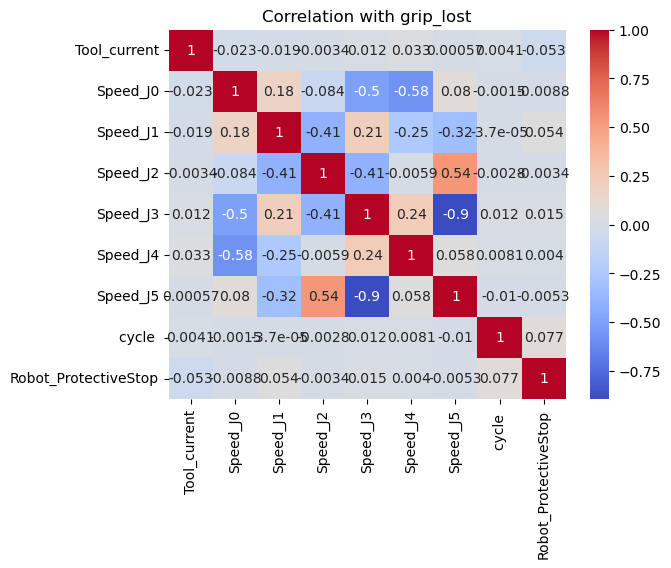

In [35]:
correlation_matrix = df[['Tool_current', 'Speed_J0', 'Speed_J1', 'Speed_J2', 
                         'Speed_J3', 'Speed_J4', 'Speed_J5', 'cycle ', 'Robot_ProtectiveStop']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation with grip_lost")
plt.show()

Well, since the heatmaps could not show any correlation between the features and the target variables, this means that the relationship is not linear, but a **non-linear one**; probably **sequence of events**. This is common for a time series data, where patterns of operation will result in the faults rather than solely by features independently; **i.e. temporal patterns**

In [38]:
print("grip_lost distribution:")
print(df['grip_lost'].value_counts(normalize=True))
print("\nRobot_ProtectiveStop distribution:")
print(df['Robot_ProtectiveStop'].value_counts(normalize=True))

# Summary stats for key features
df_currents = df[['Current_J0', 'Current_J1', 'Current_J2', 'Current_J3', 'Current_J4', 'Current_J5', 'Tool_current']]
df_currents.describe()

grip_lost distribution:
grip_lost
False    0.967202
True     0.032798
Name: proportion, dtype: float64

Robot_ProtectiveStop distribution:
Robot_ProtectiveStop
False    0.95519
True     0.04481
Name: proportion, dtype: float64


,Current_J0,Current_J1,Current_J2,Current_J3,Current_J4,Current_J5,Tool_current
count,7363.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000
mean,-0.048934,-2.297936,-1.199381,-0.605312,-0.022968,0.000904,0.109527
std,0.829395,0.800450,0.609984,0.514937,0.630789,0.129141,0.078832
min,-6.247756,-5.808734,-4.171966,-3.333102,-4.738406,-0.474556,0.020180
25%,-0.195026,-2.664919,-1.552803,-0.830933,-0.125809,-0.094875,0.082387
50%,-0.080830,-2.236342,-1.077137,-0.571190,-0.012325,0.014496,0.085192
75%,0.095959,-1.778334,-0.838721,-0.388398,0.086098,0.077995,0.089518
max,6.806938,1.083596,2.464940,2.270268,4.089389,0.392547,0.602054


In [40]:
# window = 20
# fault_indices = df[df['grip_lost'] == 1].index
# fault_indices = df[df['Robot_ProtectiveStop'] == 1].index

# for idx in fault_indices[:5]:  # First 5 grip_lost events
#     start = max(0, idx - window)
#     event_data = df.iloc[start:idx+1]
#     plt.plot(event_data['Timestamp'], event_data['Tool_current'], label='Tool_current')
#     plt.plot(event_data['Timestamp'], event_data['Current_J0'], label='Current_J0')
#     plt.plot(event_data['Timestamp'], event_data['Current_J1'], label='Current_J1')
#     plt.plot(event_data['Timestamp'], event_data['Current_J2'], label='Current_J2')
#     plt.plot(event_data['Timestamp'], event_data['Current_J3'], label='Current_J3')
#     plt.plot(event_data['Timestamp'], event_data['Current_J4'], label='Current_J4')
#     plt.plot(event_data['Timestamp'], event_data['Current_J5'], label='Current_J5')
#     plt.axvline(df['Timestamp'].iloc[idx], color='r', linestyle='--', label='Robot_ProtectiveStop')
#     plt.legend()
#     plt.title(f"grip_lost at Index {idx}")
#     plt.show()


In [42]:
# Mean and std for Tool_current in fault vs. normal
# print("Tool_current stats:")
# print("grip_lost = 1:", df[df['grip_lost'] == 1]['Tool_current'].describe())
# print("grip_lost = 0:", df[df['grip_lost'] == 0]['Tool_current'].describe())

In [44]:
# Detect transitions from 0 to 1
df['grip_lost_transition'] = (df['grip_lost'].diff() == 1).astype(int)
df['Robot_ProtectiveStop_transition'] = (df['Robot_ProtectiveStop'].diff() == 1).astype(int)

# print(df['grip_lost'].value_counts())
# print(df['Robot_ProtectiveStop'].value_counts())
# print(df['grip_lost_transition'].value_counts())
# print(df['Robot_ProtectiveStop_transition'].value_counts())

# Get indices where transitions occur
grip_lost_onsets = df[df['grip_lost_transition'] == 1].index
protective_stop_onsets = df[df['Robot_ProtectiveStop_transition'] == 1].index

print(f"grip_lost onsets: {len(grip_lost_onsets)}")
print(f"Robot_ProtectiveStop onsets: {len(protective_stop_onsets)}")

grip_lost onsets: 154
Robot_ProtectiveStop onsets: 320


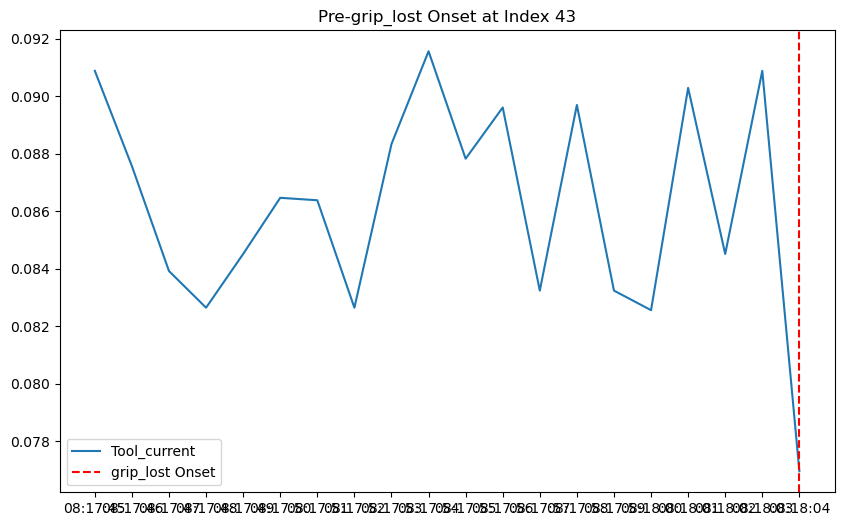

Pre-grip_lost at 43:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.086184    0.040288
std        0.003800    0.129649
min        0.076960   -0.268139
25%        0.083239    0.029501
50%        0.086422    0.074667
75%        0.089626    0.095682
max        0.091557    0.259854


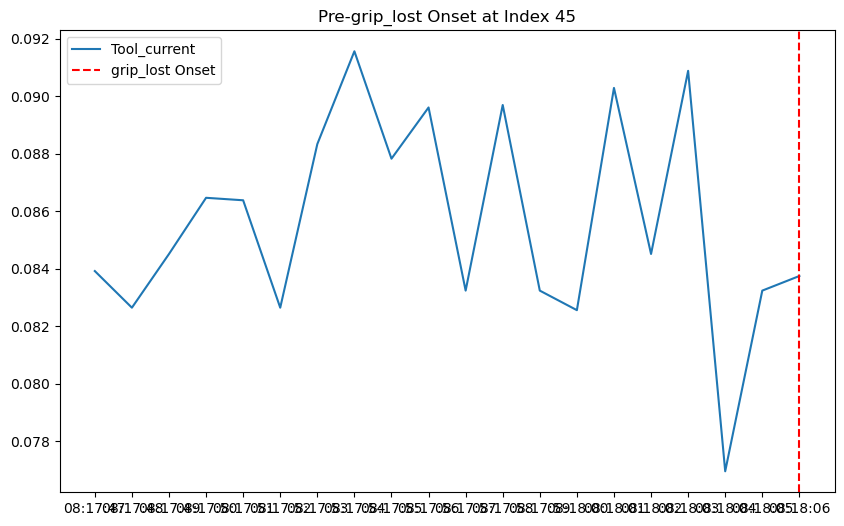

Pre-grip_lost at 45:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.085612    0.049647
std        0.003689    0.135509
min        0.076960   -0.268139
25%        0.083239    0.029501
50%        0.084512    0.078652
75%        0.088650    0.129709
max        0.091557    0.259854


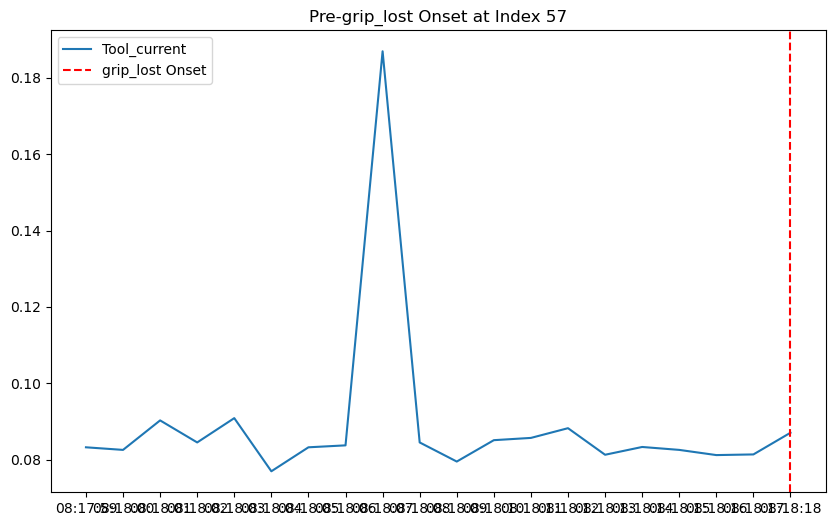

Pre-grip_lost at 57:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.089112    0.050656
std        0.023275    0.138084
min        0.076960   -0.210292
25%        0.082263    0.020882
50%        0.083536    0.056173
75%        0.086039    0.167343
max        0.186950    0.259854


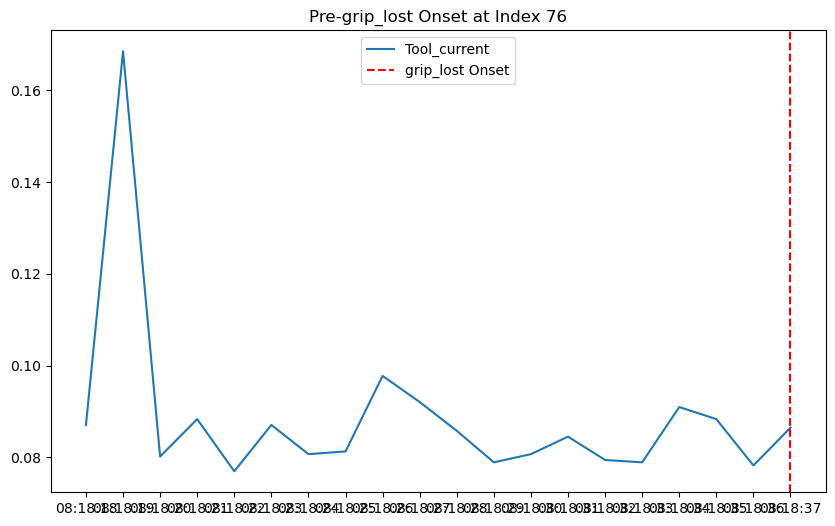

Pre-grip_lost at 76:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.088608   -0.007751
std        0.019587    0.076165
min        0.076960   -0.235956
25%        0.079994   -0.000914
50%        0.085149    0.010706
75%        0.088331    0.025514
max        0.168534    0.099673


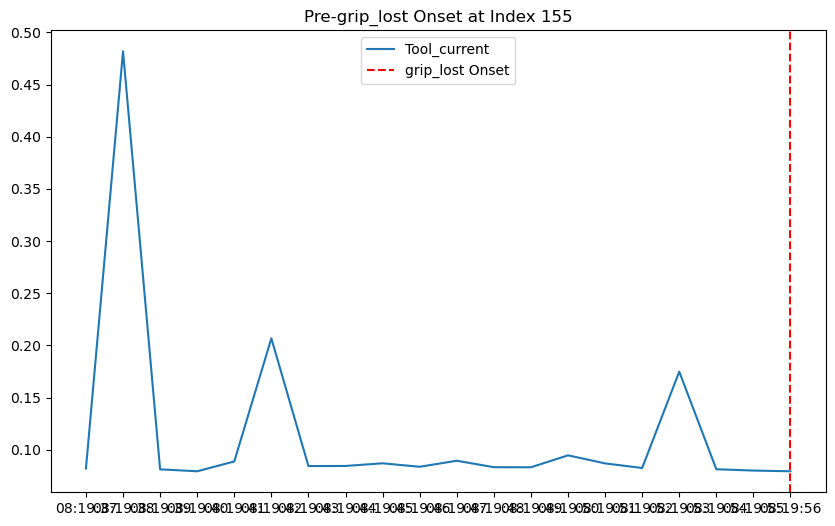

Pre-grip_lost at 155:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.114807   -0.006111
std        0.092605    0.173204
min        0.079420   -0.368248
25%        0.081882   -0.133414
50%        0.084086    0.004971
75%        0.089009    0.118612
max        0.481879    0.261619


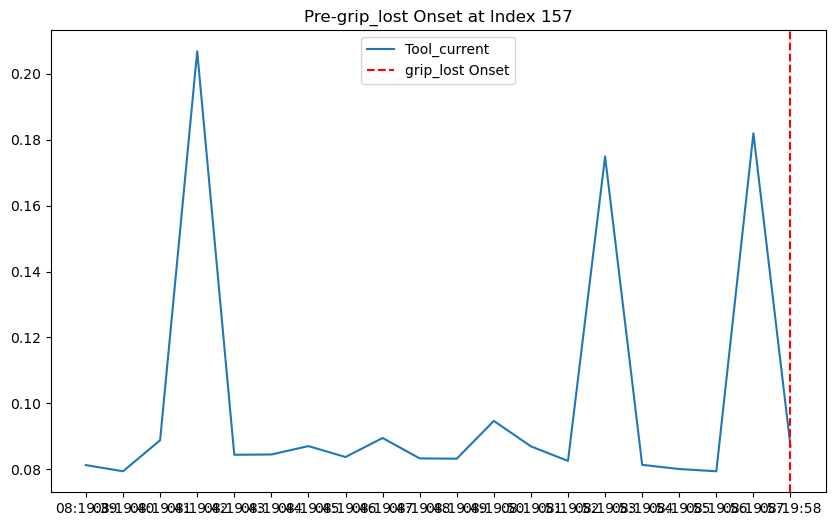

Pre-grip_lost at 157:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.100056   -0.006998
std        0.038425    0.165331
min        0.079420   -0.368248
25%        0.082263   -0.121434
50%        0.084469    0.004971
75%        0.089009    0.118612
max        0.206812    0.227952


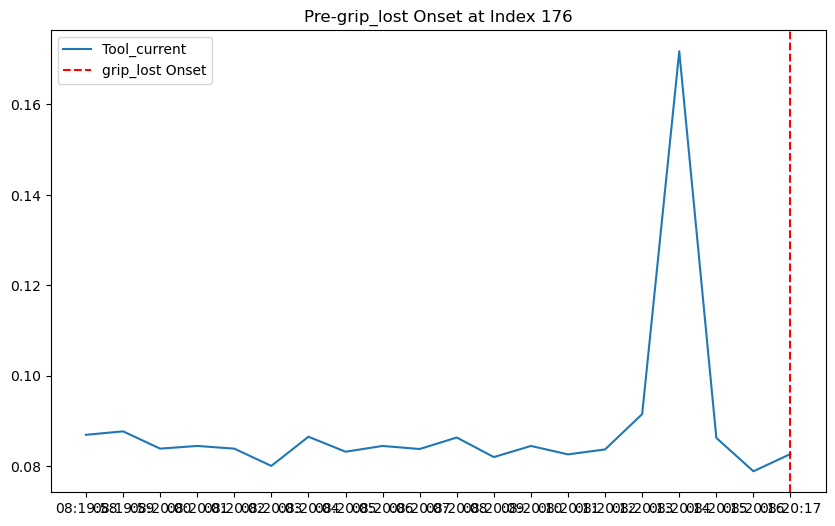

Pre-grip_lost at 176:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.088794    0.058789
std        0.019721    0.079644
min        0.078913   -0.109809
25%        0.083112    0.039278
50%        0.084216    0.051797
75%        0.086422    0.069481
max        0.171760    0.246970


In [54]:
window = 20  # Look 20 timesteps before the fault turns on

for idx in grip_lost_onsets[:7]:  # First 5 transitions
    start = max(0, idx - window)
    pre_fault_data = df.iloc[start:idx]  # Exclude the fault onset itself
    if len(pre_fault_data) < window:  # Skip if not enough data
        continue
    
    plt.figure(figsize=(10, 6))
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Tool_current'], label='Tool_current')
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J1'], label='Current_J1')
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J2'], label='Current_J2')
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J3'], label='Current_J3')
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J4'], label='Current_J4')
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J5'], label='Current_J5')
    plt.axvline(df['Timestamp'].iloc[idx-1], color='r', linestyle='--', label='grip_lost Onset')
    plt.legend()
    plt.title(f"Pre-grip_lost Onset at Index {idx}")
    plt.show()

    # Stats for this window
    print(f"Pre-grip_lost at {idx}:")
    print(pre_fault_data[['Tool_current', 'Current_J5']].describe())

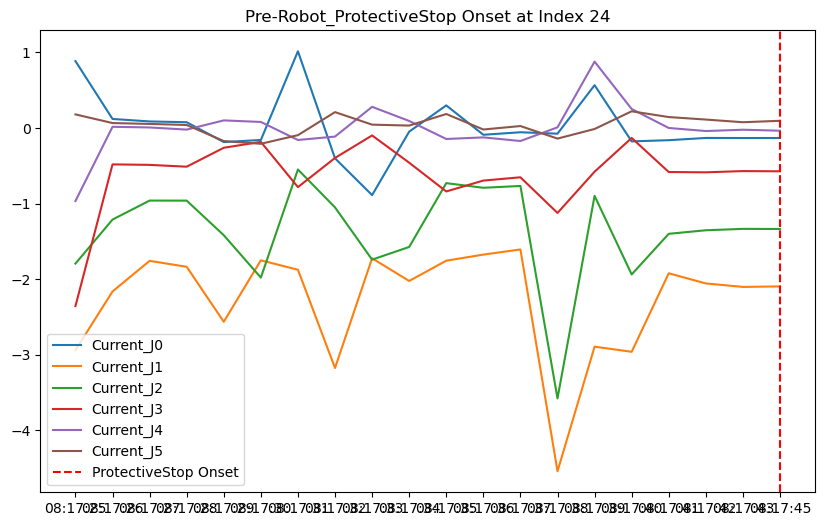

Pre-ProtectiveStop at 24:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.095673    0.041139
std        0.029417    0.123132
min        0.078827   -0.209541
25%        0.083919   -0.015425
50%        0.086082    0.048444
75%        0.088458    0.119233
max        0.188310    0.220357


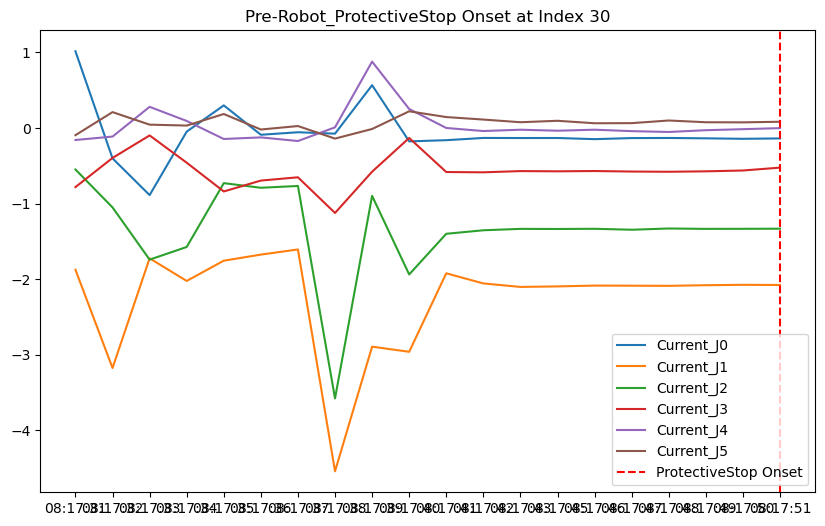

Pre-ProtectiveStop at 30:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.090360    0.066251
std        0.019846    0.090312
min        0.078827   -0.140795
25%        0.083749    0.029867
50%        0.085742    0.074667
75%        0.087587    0.101679
max        0.172947    0.220357


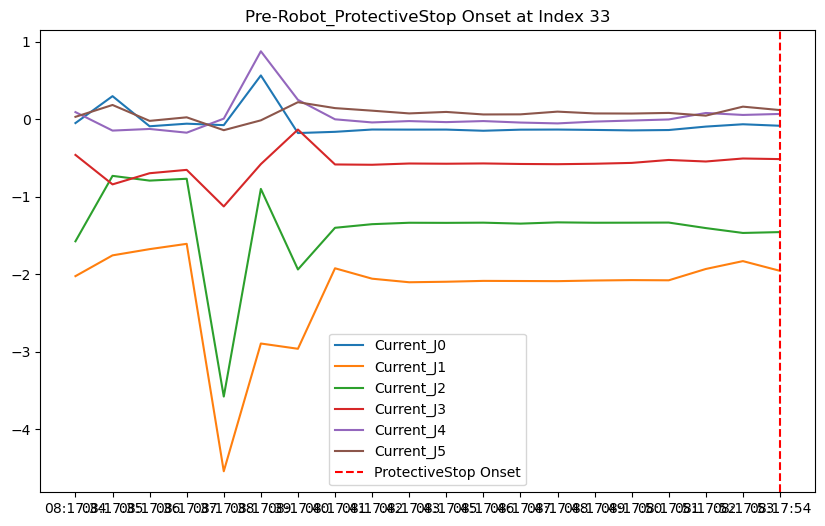

Pre-ProtectiveStop at 33:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.090746    0.074776
std        0.019660    0.079092
min        0.082646   -0.140795
25%        0.083919    0.042901
50%        0.086422    0.075532
75%        0.087822    0.112897
max        0.172947    0.220357


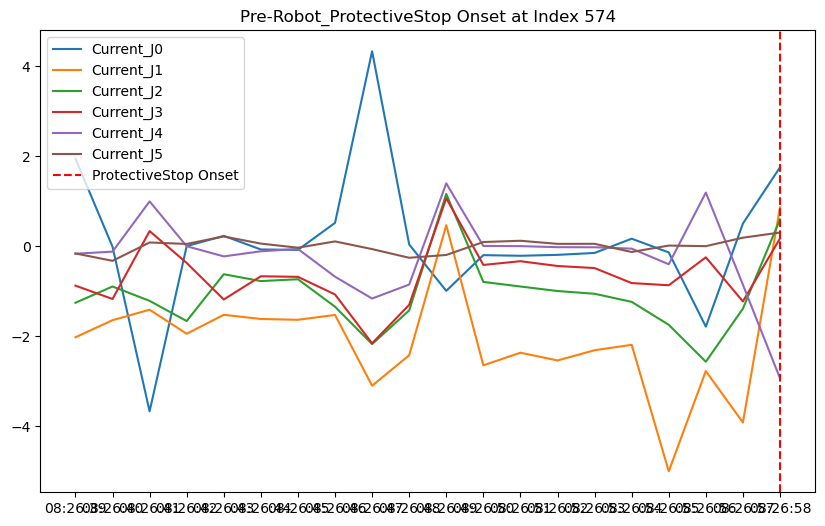

Pre-ProtectiveStop at 574:
       Tool_current  Current_J5
count     20.000000   20.000000
mean       0.125925    0.006167
std        0.103147    0.159611
min        0.080186   -0.327745
25%        0.082411   -0.083151
50%        0.084598    0.048527
75%        0.092512    0.093555
max        0.495117    0.301449


In [47]:
for idx in protective_stop_onsets[:5]:  # First 5 transitions
    start = max(0, idx - window)
    pre_fault_data = df.iloc[start:idx]
    if len(pre_fault_data) < window:
        continue
    
    plt.figure(figsize=(10, 6))
    # plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Tool_current'], label='Tool_current')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J0'], label='Current_J0')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J1'], label='Current_J1')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J2'], label='Current_J2')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J3'], label='Current_J3')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J4'], label='Current_J4')
    plt.plot(pre_fault_data['Timestamp'], pre_fault_data['Current_J5'], label='Current_J5')
    plt.axvline(df['Timestamp'].iloc[idx-1], color='r', linestyle='--', label='ProtectiveStop Onset')
    plt.legend()
    plt.title(f"Pre-Robot_ProtectiveStop Onset at Index {idx}")
    plt.show()

    print(f"Pre-ProtectiveStop at {idx}:")
    print(pre_fault_data[['Tool_current', 'Current_J5']].describe())

In [50]:
# For grip_lost
pre_grip_lost_data = []
for idx in grip_lost_onsets:
    start = max(0, idx - window)
    pre_fault_data = df.iloc[start:idx]
    if len(pre_fault_data) == window:
        pre_grip_lost_data.append(pre_fault_data[['Tool_current', 'Current_J5', 'Speed_J5']])

pre_grip_lost_df = pd.concat(pre_grip_lost_data)
print("Aggregate pre-grip_lost stats:")
print(pre_grip_lost_df.describe())

# For Robot_ProtectiveStop
pre_stop_data = []
for idx in protective_stop_onsets:
    start = max(0, idx - window)
    pre_fault_data = df.iloc[start:idx]
    if len(pre_fault_data) == window:
        pre_stop_data.append(pre_fault_data[['Tool_current', 'Current_J5', 'Speed_J5']])

pre_stop_df = pd.concat(pre_stop_data)
print("Aggregate pre-ProtectiveStop stats:")
print(pre_stop_df.describe())

Aggregate pre-grip_lost stats:
       Tool_current   Current_J5     Speed_J5
count   3050.000000  3050.000000  3050.000000
mean       0.105749     0.001932     0.004762
std        0.070608     0.131052     0.332416
min        0.073820    -0.474556    -1.621577
25%        0.081966    -0.099860    -0.003949
50%        0.085192     0.013260     0.000000
75%        0.089518     0.078561     0.012052
max        0.561316     0.358622     1.378015
Aggregate pre-ProtectiveStop stats:
       Tool_current   Current_J5     Speed_J5
count   6273.000000  6273.000000  6273.000000
mean       0.112342     0.000505    -0.001438
std        0.085325     0.130709     0.321120
min        0.073055    -0.454900    -1.629721
25%        0.082560    -0.097394    -0.000988
50%        0.085192     0.014352     0.000000
75%        0.089432     0.079704     0.015584
max        0.570228     0.341363     1.364226


# Data Preprocessing

In [9]:
df.describe()

,Num,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,...,Temperature_J5,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop
count,7409.000000,7363.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,...,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7355.000000,7409.000000,7355.000000
mean,3705.000000,-0.048934,34.906781,-2.297936,37.659636,-1.199381,38.064064,-0.605312,40.936999,-0.022968,...,41.891094,0.001671,0.000061,0.003791,-0.004610,-0.000810,0.002880,0.109527,141.113241,0.037797
std,2138.938405,0.829395,2.762057,0.800450,3.247315,0.609984,3.311948,0.514937,3.182399,0.630789,...,3.680003,0.148826,0.049370,0.729422,0.359999,0.038436,0.313953,0.078832,80.542340,0.190719
min,1.000000,-6.247756,27.812500,-5.808734,29.312500,-4.171966,29.375000,-3.333102,32.125000,-4.738406,...,32.000000,-0.656331,-0.330833,-2.733091,-1.271460,-0.226233,-1.629721,0.020180,1.000000,0.000000
25%,1853.000000,-0.195026,33.000000,-2.664919,35.375000,-1.552803,35.750000,-0.830933,38.937500,-0.125809,...,39.500000,-0.000483,-0.000659,-0.004100,-0.005365,-0.000120,-0.000803,0.082387,68.000000,0.000000
50%,3705.000000,-0.080830,36.500000,-2.236342,39.687500,-1.077137,40.187500,-0.571190,43.062500,-0.012325,...,44.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085192,154.000000,0.000000
75%,5557.000000,0.095959,37.062500,-1.778334,40.125000,-0.838721,40.437500,-0.388398,43.125000,0.086098,...,44.500000,0.002115,0.000540,0.000205,0.009912,0.000066,0.012924,0.089518,218.000000,0.000000
max,7409.000000,6.806938,37.250000,1.083596,40.500000,2.464940,40.937500,2.270268,43.437500,4.089389,...,44.937500,0.791929,0.615526,2.679848,1.363093,0.193914,1.378015,0.602054,264.000000,1.000000


## Data Imputation

In [62]:
# df.isna().mean()*100
nan_rows = df.isna().any(axis=1)
print(df.loc[(nan_rows)]['grip_lost'].value_counts())
print(df.loc[(nan_rows)]['Robot_ProtectiveStop'].value_counts())

grip_lost
False    54
Name: count, dtype: int64
Series([], Name: count, dtype: int64)


Having less than 1% of the data missing for several readings would likely be more a **sensor error** rather than an event that led to failure, which is shown above that nan values were not the trigger to faults. Thus, it can be dropped or imputed. I am more inclined to impute it with **linear** due to the temporal nature of the dataframe and continuous readings

In [70]:
df.interpolate(method='linear', inplace=True)

C:\Users\Mohammed Ashraf\AppData\Local\Temp\ipykernel_6952\2868764835.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [72]:
df.isna().mean()*100

Num                     0.0
Timestamp               0.0
Current_J0              0.0
Temperature_T0          0.0
Current_J1              0.0
Temperature_J1          0.0
Current_J2              0.0
Temperature_J2          0.0
Current_J3              0.0
Temperature_J3          0.0
Current_J4              0.0
Temperature_J4          0.0
Current_J5              0.0
Temperature_J5          0.0
Speed_J0                0.0
Speed_J1                0.0
Speed_J2                0.0
Speed_J3                0.0
Speed_J4                0.0
Speed_J5                0.0
Tool_current            0.0
cycle                   0.0
Robot_ProtectiveStop    0.0
grip_lost               0.0
dtype: float64

## Outlier detection and removal

This one is tricky since the outliers might be one of the reasons that trigger faults. Also, having less than **5%** of the data as faults makes it harder just to remove outliers blindly. Thus, checking for the amount of faults, **within for example, IQR,** would provide insights on whether the spikes are the reason of faults or not

In [89]:
df.describe()

,Num,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,...,Temperature_J5,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop
count,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,...,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000,7409.000000
mean,3705.000000,-0.049071,34.916145,-2.297643,37.670435,-1.199656,38.074875,-0.605224,40.947007,-0.022883,...,41.902049,0.001766,0.000106,0.003549,-0.004544,-0.000852,0.002717,0.109623,141.113241,0.037657
std,2138.938405,0.828891,2.758806,0.799180,3.243391,0.608910,3.307690,0.514009,3.177802,0.629543,...,3.674504,0.148605,0.049286,0.728524,0.359405,0.038407,0.313427,0.078769,80.542340,0.190201
min,1.000000,-6.247756,27.812500,-5.808734,29.312500,-4.171966,29.375000,-3.333102,32.125000,-4.738406,...,32.000000,-0.656331,-0.330833,-2.733091,-1.271460,-0.226233,-1.629721,0.020180,1.000000,0.000000
25%,1853.000000,-0.195054,33.000000,-2.663814,35.375000,-1.552651,35.812500,-0.830620,38.937500,-0.125804,...,39.562500,-0.000490,-0.000701,-0.004197,-0.005735,-0.000128,-0.000839,0.082473,68.000000,0.000000
50%,3705.000000,-0.080634,36.562500,-2.234930,39.687500,-1.077494,40.187500,-0.571190,43.062500,-0.012566,...,44.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085192,154.000000,0.000000
75%,5557.000000,0.096384,37.062500,-1.778651,40.125000,-0.838983,40.437500,-0.388090,43.125000,0.086163,...,44.500000,0.002375,0.000575,0.000226,0.010942,0.000068,0.014061,0.089518,218.000000,0.000000
max,7409.000000,6.806938,37.250000,1.083596,40.500000,2.464940,40.937500,2.270268,43.437500,4.089389,...,44.937500,0.791929,0.615526,2.679848,1.363093,0.193914,1.378015,0.602054,264.000000,1.000000


In [95]:
df[df.grip_lost == True].describe()

,Num,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,...,Temperature_J5,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,3008.288066,0.005904,33.603909,-2.017274,36.104424,-0.966972,36.443673,-0.667481,39.299897,-0.087472,...,40.030607,0.020005,-0.005029,0.146782,-0.073057,-0.014029,0.048957,0.096362,115.337449,0.012346
std,2366.562180,0.601167,3.530728,0.509308,4.132119,0.366523,4.236910,0.266813,4.150764,0.355446,...,4.711719,0.114196,0.019139,0.600261,0.382666,0.033295,0.352174,0.044043,90.681814,0.110651
min,44.000000,-2.395309,27.937500,-4.336777,29.500000,-2.631781,29.625000,-1.861192,32.312500,-4.060150,...,32.312500,-0.395030,-0.095336,-2.525100,-1.154806,-0.112536,-1.553685,0.076194,2.000000,0.000000
25%,417.500000,-0.179904,29.312500,-2.455471,31.062500,-0.993723,31.250000,-0.844528,34.218750,-0.179023,...,34.312500,-0.000097,-0.006777,-0.001453,-0.288944,-0.031316,0.000000,0.082517,15.000000,0.000000
50%,2467.000000,-0.079560,34.000000,-1.767407,36.500000,-0.842248,37.000000,-0.679517,39.937500,-0.089031,...,40.687500,0.000000,-0.000046,0.000000,-0.000165,0.000000,0.017489,0.085192,92.000000,0.000000
75%,5226.500000,0.105224,37.000000,-1.641585,40.000000,-0.761822,40.375000,-0.557880,43.125000,-0.007077,...,44.437500,0.077606,0.000000,0.006854,0.000000,0.000797,0.167067,0.089604,208.000000,0.000000
max,7335.000000,5.510250,37.250000,-0.357726,40.500000,-0.239741,40.875000,0.100366,43.437500,2.171204,...,44.937500,0.285812,0.138693,2.654043,1.323597,0.056062,1.313973,0.480941,262.000000,1.000000


In [97]:
df[df.Robot_ProtectiveStop == True].describe()

,Num,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,...,Temperature_J5,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,278.000000,2.780000e+02,278.000000,278.000000,278.000000,278.000000,2.780000e+02,278.000000,278.000000,278.0
mean,4339.863309,0.025680,35.725045,-2.736537,38.618480,-1.534398,39.032149,-0.777138,41.837005,0.031782,...,42.923112,-4.933039e-03,0.013606,-0.008599,0.022267,-0.000035,-5.524189e-03,0.088440,166.021583,1.0
std,1951.870972,0.590388,2.237747,0.986691,2.623968,0.755899,2.667736,0.687102,2.551584,0.711179,...,2.950649,3.828037e-02,0.085497,0.093852,0.098161,0.009642,4.658905e-02,0.038919,73.076931,0.0
min,20.000000,-2.274941,27.875000,-4.640350,29.437500,-3.652554,29.500000,-3.333102,32.250000,-4.738406,...,32.125000,-3.323348e-01,-0.184411,-1.517925,-0.122624,-0.030279,-3.089913e-01,0.074500,1.000000,1.0
25%,2800.750000,-0.122816,34.375000,-3.471504,37.125000,-1.979194,37.562500,-1.121089,40.500000,-0.052083,...,41.187500,-8.128802e-05,-0.000194,-0.000063,-0.000068,0.000000,-4.013261e-35,0.081966,103.000000,1.0
50%,4656.500000,-0.020977,36.937500,-2.822194,39.937500,-1.613609,40.312500,-0.993316,43.125000,0.018759,...,44.437500,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.084426,188.000000,1.0
75%,5900.750000,0.084631,37.125000,-2.177897,40.250000,-1.328059,40.625000,-0.583339,43.250000,0.235764,...,44.500000,4.718873e-43,0.000312,0.000033,0.000192,0.000000,1.403101e-08,0.086379,228.750000,1.0
max,7377.000000,6.806938,37.250000,1.083596,40.437500,1.818832,40.875000,1.554981,43.437500,3.067085,...,44.875000,1.295584e-01,0.615526,0.068322,0.782787,0.142246,1.852282e-01,0.501310,264.000000,1.0


In [173]:
joint = 0
df[f'Speed_J{joint}'].skew()

0.20133305385195385

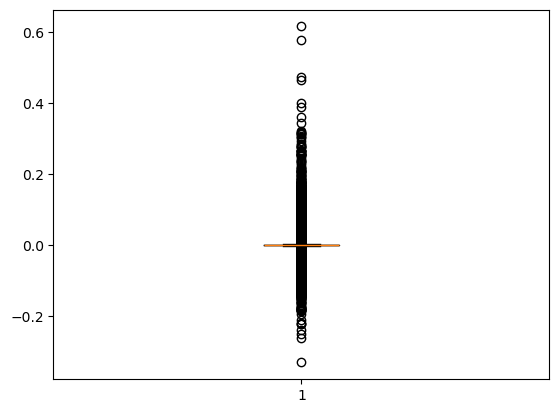

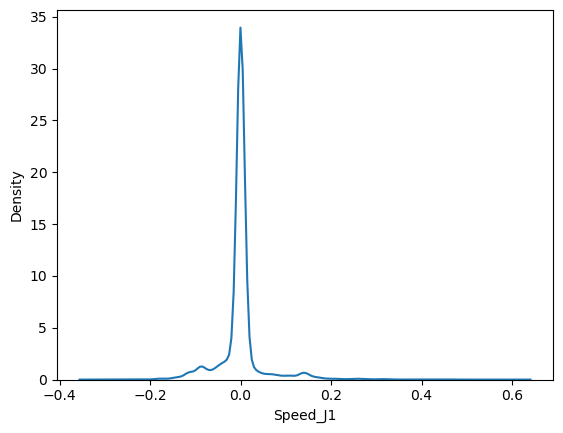

In [408]:
var = 'Speed'
joint = 1
plt.boxplot(df[f'{var}_J{joint}'])
plt.show()
sns.kdeplot(df[f'{var}_J{joint}'])
plt.show()

In [410]:
from scipy.stats import skew, kurtosis
print(f"Skewness Current_J1: {skew(df['Speed_J0'])}")
print(f"Kurtosis Current_J1: {kurtosis(df['Speed_J0']) + 3}")  # +3 to align with excess kurtosis

Skewness Current_J1: 0.2012922903796624
Kurtosis Current_J1: 10.481219658348719


In [466]:
var = 'Speed'
joint = 1
window = 5
df['Speed_J1'+'ma'] = df[f'{var}_J{joint}'].rolling(window=window,closed='left').std()
df['Speed_J1'+'ma']
# plt.plot(df[f'{var}_J{joint}'])
# plt.show()
# df.loc[df.Speed_J1 == df['Speed_J1'].max()]
# df.iloc[5903]

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
7404    0.007587
7405    0.000158
7406    0.000158
7407    0.000000
7408    0.000000
Name: Speed_J1ma, Length: 7409, dtype: float64

The distribution of currents **J1-5** seem to be the only features that are not normal

In [266]:
var = 'Speed'
joint = 0
Q3 = df[f'{var}_J{joint}'].quantile(0.75)
Q1 = df[f'{var}_J{joint}'].quantile(0.25)
floor = df[f'{var}_J{joint}'] < Q3
ceil = df[f'{var}_J{joint}'] > Q1
df.loc[(floor) & (ceil)]

,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost
1,2,08:17:22,0.595605,27.8750,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,...,-7.391485e-30,-0.000304,0.002185,1.668227e-03,-7.668273e-04,4.169016e-04,0.505895,1,0.0,False
5,6,08:17:26,0.118961,27.8125,-2.162542,29.3750,-1.211779,29.4375,-0.481834,32.1875,...,-4.639511e-05,0.000093,0.000262,2.170784e-03,2.647067e-04,-2.470161e-03,0.188310,1,0.0,False
6,7,08:17:27,0.086138,27.8750,-1.757647,29.3750,-0.960634,29.4375,-0.488380,32.1875,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.121039e-44,0.085192,1,0.0,False
7,8,08:17:28,0.075657,27.8750,-1.836465,29.3750,-0.961322,29.4375,-0.512541,32.1875,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.087058,1,0.0,False
13,14,08:17:34,-0.048898,27.8750,-2.023628,29.4375,-1.574188,29.4375,-0.459635,32.2500,...,0.000000e+00,0.000000,-0.000265,5.332777e-21,-4.225521e-32,0.000000e+00,0.083153,1,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,7405,15:36:02,-0.109017,37.1875,-2.261695,40.3125,-1.082678,40.6875,-0.494714,43.3750,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.080013,264,0.0,False
7405,7406,15:36:03,-0.098536,37.1875,-2.251992,40.3125,-1.094420,40.6875,-0.515789,43.3750,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.078740,264,0.0,False
7406,7407,15:36:04,-0.121100,37.1875,-2.280791,40.2500,-1.121319,40.6875,-0.502406,43.3750,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.091471,264,0.0,False
7407,7408,15:36:05,-0.129370,37.1875,-2.269061,40.3125,-1.091610,40.6250,-0.491158,43.3750,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.090026,264,0.0,False


Nearly half of the dataframe is classified as an **outlier** if **IQR** is used. Thus, trying **Z-score** will yield the results below

In [286]:
from scipy import stats
var = 'Speed'
joint = 5
z = np.abs(stats.zscore(df[f'{var}_J{joint}']))
filtered_entries = z < 3
df_zscore_filter = df[filtered_entries]
print(df.shape)
print(df_zscore_filter.shape)

(7409, 24)
(7248, 24)


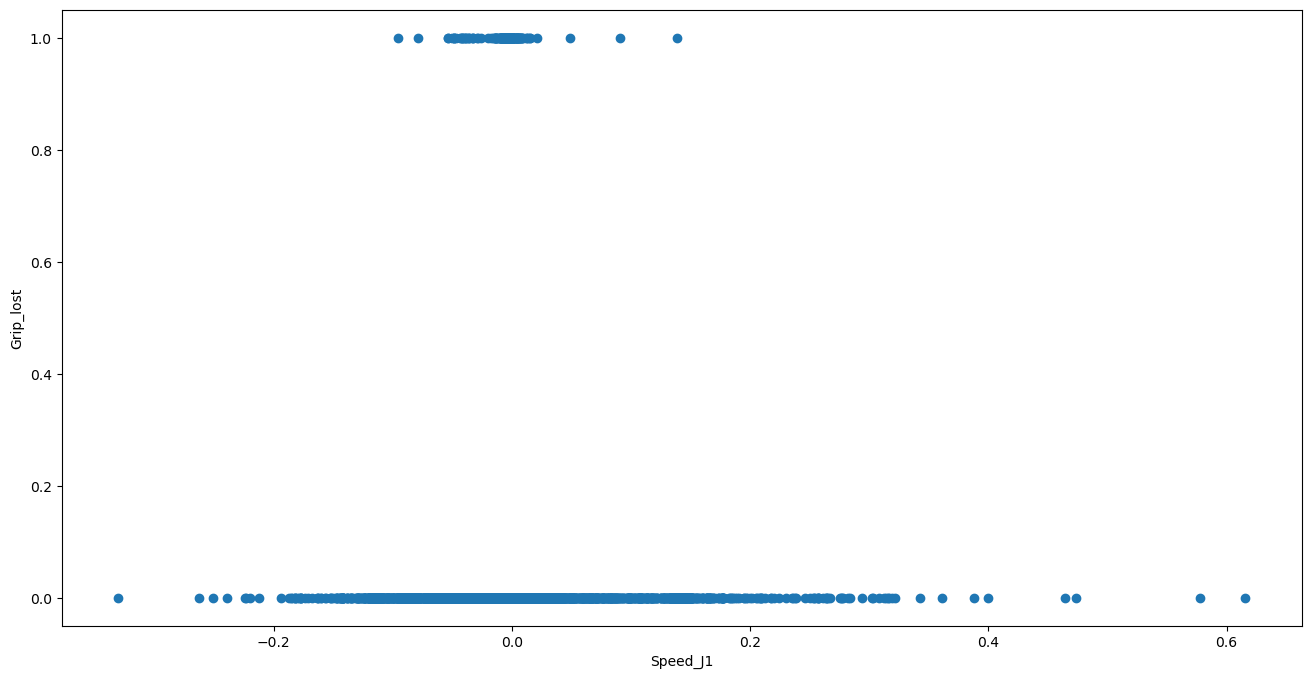

In [320]:
var = 'Speed'
joint = 1
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[f'{var}_J{joint}'], df.grip_lost)
ax.set_xlabel(f'{var}_J{joint}')
ax.set_ylabel('Grip_lost')
plt.show()

## Model selection and Training

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import mlflow
import warnings
warnings.filterwarnings('ignore')
os.environ["GIT_PYTHON_GIT_EXECUTABLE"] = "D:/Git/Git/bin/git.exe"